<a href="https://colab.research.google.com/github/Andreyhok/BI_ML_2021/blob/lesson_8_neural_networks_part2/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [2]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [3]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ: скорее всего чем больше этот параметр, тем быстрее будет учиться нейросеть, так как она меньше раз сделает forward и backward.**

Посмотрим на какую-нибудь картинку:

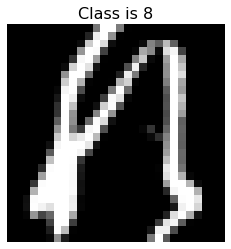

In [4]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





In [11]:
images = []
s = []
for image in trainset:
  if len(s) == 10:
    break
  if image[1] not in s:
    images.append(image)
    s.append(image[1])
  else:
    continue



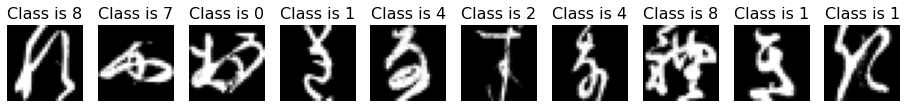

In [23]:
fig = plt.figure(figsize=(16,16))
for index in range(10):
  plt.subplot(1,10,index + 1)
  plt.imshow(trainset[index][0].view(28, 28).numpy(), cmap="gray")
  plt.axis("off")
  plt.title(f"Class is {trainset[index][1]}", fontsize=16);



### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [88]:
import torch.nn as nn
import torch.nn.functional as F 
class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features= 256, out_features = 128)
        self.fc3 = nn.Linear(in_features= 128, out_features = 10)

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        logits = self.fc3(x)

        ## YOUR CODE HERE

        return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ: 1956**

In [34]:
nn = FCNet()

In [35]:
for param in nn.parameters():
    print(param.shape)

torch.Size([256, 784])
torch.Size([256])
torch.Size([128, 256])
torch.Size([128])
torch.Size([10, 128])
torch.Size([10])


### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [25]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [30]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
#optimizer = torch.optim.SGD(fc_net.parameters(), lr=lr)
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [31]:
%%time
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
  epoch_loss = 0
  for images, labels in trainloader:
    optimizer.zero_grad()
    outputs = fc_net(images)
    loss = loss_function(outputs,labels)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
  loss_history.append(epoch_loss / len(trainloader))
  print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")
## YOUR CODE HERE


Epoch=1 loss=0.9237
Epoch=2 loss=0.4543
Epoch=3 loss=0.3580
Epoch=4 loss=0.3000
Epoch=5 loss=0.2598
Epoch=6 loss=0.2254
Epoch=7 loss=0.1960
Epoch=8 loss=0.1727
Epoch=9 loss=0.1527
Epoch=10 loss=0.1347
CPU times: user 30.6 s, sys: 2.03 s, total: 32.7 s
Wall time: 1min 6s


In [32]:
get_accuracy(fc_net, testloader)

0.8736

In [33]:
# При использовании SGD accuracy было 0.3, с adam получилось 0.87 - намного лучше)

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [85]:
a = []

for i in trainset:
  a.append(i[0].mean())
  
a = np.array(a)


In [86]:
mean = a.mean()## calculate mean
std = a.std()## calculate std
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

0.19176215 0.06591723


In [92]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
#optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
optimizer = torch.optim.SGD(fc_net.parameters(), lr=lr)

In [93]:
n_epochs2 = 10
loss_history2 = []
for epoch in range(n_epochs2):
  epoch_loss = 0
  for images, labels in trainloader:
    optimizer.zero_grad()
    outputs = fc_net(images)
    loss = loss_function(outputs,labels)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
  loss_history2.append(epoch_loss / len(trainloader))
  print(f"Epoch={epoch+1} loss={loss_history2[epoch]:.4f}")


Epoch=1 loss=1.9182
Epoch=2 loss=1.2746
Epoch=3 loss=0.9628
Epoch=4 loss=0.8084
Epoch=5 loss=0.7154
Epoch=6 loss=0.6529
Epoch=7 loss=0.6067
Epoch=8 loss=0.5704
Epoch=9 loss=0.5417
Epoch=10 loss=0.5164


In [94]:
get_accuracy(fc_net, testloader)

0.7115

Как изменилась `accuracy` после нормализации?

In [95]:
# Если использовать в качестве оптимайзера Adam, то accuracy теперь равно 0.9033, 
# если использовать в качестве оптимайзера SGD, то accuracy теперь равно 0.7115, что намного лучше чем было!

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [97]:
## YOUR CODE HERE
class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features= 256, out_features = 128)
        self.fc3 = nn.Linear(in_features= 128, out_features = 10)

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        logits = self.fc3(x)

        ## YOUR CODE HERE

        return logits

In [98]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
#optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
optimizer = torch.optim.SGD(fc_net.parameters(), lr=lr)

In [99]:


%%time
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
  epoch_loss = 0
  for images, labels in trainloader:
    optimizer.zero_grad()
    outputs = fc_net(images)
    loss = loss_function(outputs,labels)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
  loss_history.append(epoch_loss / len(trainloader))
  print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch=1 loss=2.3245
Epoch=2 loss=2.2953
Epoch=3 loss=2.2832
Epoch=4 loss=2.2740
Epoch=5 loss=2.2654
Epoch=6 loss=2.2568
Epoch=7 loss=2.2480
Epoch=8 loss=2.2390
Epoch=9 loss=2.2297
Epoch=10 loss=2.2203
CPU times: user 26.4 s, sys: 2.07 s, total: 28.5 s
Wall time: 1min 41s


In [100]:
get_accuracy(fc_net, testloader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.3695

In [105]:
class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features= 256, out_features = 128)
        self.fc3 = nn.Linear(in_features= 128, out_features = 10)

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        x = F.gelu(x)
        logits = self.fc3(x)

        ## YOUR CODE HERE

        return logits

In [106]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
#optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
optimizer = torch.optim.SGD(fc_net.parameters(), lr=lr)

In [107]:
%%time
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
  epoch_loss = 0
  for images, labels in trainloader:
    optimizer.zero_grad()
    outputs = fc_net(images)
    loss = loss_function(outputs,labels)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
  loss_history.append(epoch_loss / len(trainloader))
  print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=1.9095
Epoch=2 loss=1.2115
Epoch=3 loss=0.9096
Epoch=4 loss=0.7672
Epoch=5 loss=0.6830
Epoch=6 loss=0.6271
Epoch=7 loss=0.5857
Epoch=8 loss=0.5533
Epoch=9 loss=0.5270
Epoch=10 loss=0.5049
CPU times: user 28.1 s, sys: 2.15 s, total: 30.3 s
Wall time: 1min 39s


In [108]:
get_accuracy(fc_net, testloader)

0.7159

In [109]:
class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features= 256, out_features = 128)
        self.fc3 = nn.Linear(in_features= 128, out_features = 10)

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        x = F.tanh(x)
        logits = self.fc3(x)

        ## YOUR CODE HERE

        return logits

In [110]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
#optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
optimizer = torch.optim.SGD(fc_net.parameters(), lr=lr)

In [111]:
%%time
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
  epoch_loss = 0
  for images, labels in trainloader:
    optimizer.zero_grad()
    outputs = fc_net(images)
    loss = loss_function(outputs,labels)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
  loss_history.append(epoch_loss / len(trainloader))
  print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch=1 loss=2.1157
Epoch=2 loss=1.7859
Epoch=3 loss=1.5648
Epoch=4 loss=1.4008
Epoch=5 loss=1.2722
Epoch=6 loss=1.1682
Epoch=7 loss=1.0840
Epoch=8 loss=1.0144
Epoch=9 loss=0.9564
Epoch=10 loss=0.9091
CPU times: user 26.9 s, sys: 2.1 s, total: 29 s
Wall time: 1min 37s


In [112]:
get_accuracy(fc_net, testloader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


0.6132

С использованием какой функции активации удалось досчить наибольшей `accuracy`?

In [113]:
# Наибольший accuracy = 0.7159 был у GELU

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [114]:
class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features= 256, out_features = 128)
        self.fc3 = nn.Linear(in_features= 128, out_features = 10)

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        x = F.gelu(x)
        logits = self.fc3(x)

        ## YOUR CODE HERE

        return logits

In [121]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
#optimizer = torch.optim.Adam(fc_net.parameters(), lr=lr)
#optimizer = torch.optim.RMSprop(fc_net.parameters(), lr=lr)
optimizer = torch.optim.Adagrad(fc_net.parameters(), lr=lr)

In [122]:
%%time
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
  epoch_loss = 0
  for images, labels in trainloader:
    optimizer.zero_grad()
    outputs = fc_net(images)
    loss = loss_function(outputs,labels)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
  loss_history.append(epoch_loss / len(trainloader))
  print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.5039
Epoch=2 loss=0.3071
Epoch=3 loss=0.2600
Epoch=4 loss=0.2320
Epoch=5 loss=0.2118
Epoch=6 loss=0.1966
Epoch=7 loss=0.1840
Epoch=8 loss=0.1733
Epoch=9 loss=0.1642
Epoch=10 loss=0.1567
CPU times: user 29.9 s, sys: 2.15 s, total: 32 s
Wall time: 1min 39s


In [123]:
get_accuracy(fc_net, testloader)

0.8626

In [124]:
# Для Adam accuracy = 0.9035
# Для RMSprop accuracy = 0.8981
# Для Adagrad accuracy = 0.8626

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [139]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        # если элемент x < 0, то 0, если >= 0, то x
        x = np.maximum(0,x)
        return x

In [143]:
class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features= 256, out_features = 128)
        self.fc3 = nn.Linear(in_features= 128, out_features = 10)
        self.activation = CustomReLU()
    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        logits = self.fc3(x)

        ## YOUR CODE HERE

        return logits

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [146]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=lr)


In [147]:
%%time
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
  epoch_loss = 0
  for images, labels in trainloader:
    optimizer.zero_grad()
    outputs = fc_net(images)
    loss = loss_function(outputs,labels)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
  loss_history.append(epoch_loss / len(trainloader))
  print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.3449
Epoch=2 loss=0.1363
Epoch=3 loss=0.0834
Epoch=4 loss=0.0565
Epoch=5 loss=0.0415
Epoch=6 loss=0.0303
Epoch=7 loss=0.0245
Epoch=8 loss=0.0219
Epoch=9 loss=0.0227
Epoch=10 loss=0.0238
CPU times: user 34.2 s, sys: 2.22 s, total: 36.4 s
Wall time: 1min 41s


In [148]:
get_accuracy(fc_net, testloader)

0.9082

In [149]:
# Примерно также, как и встроенная Relu

### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

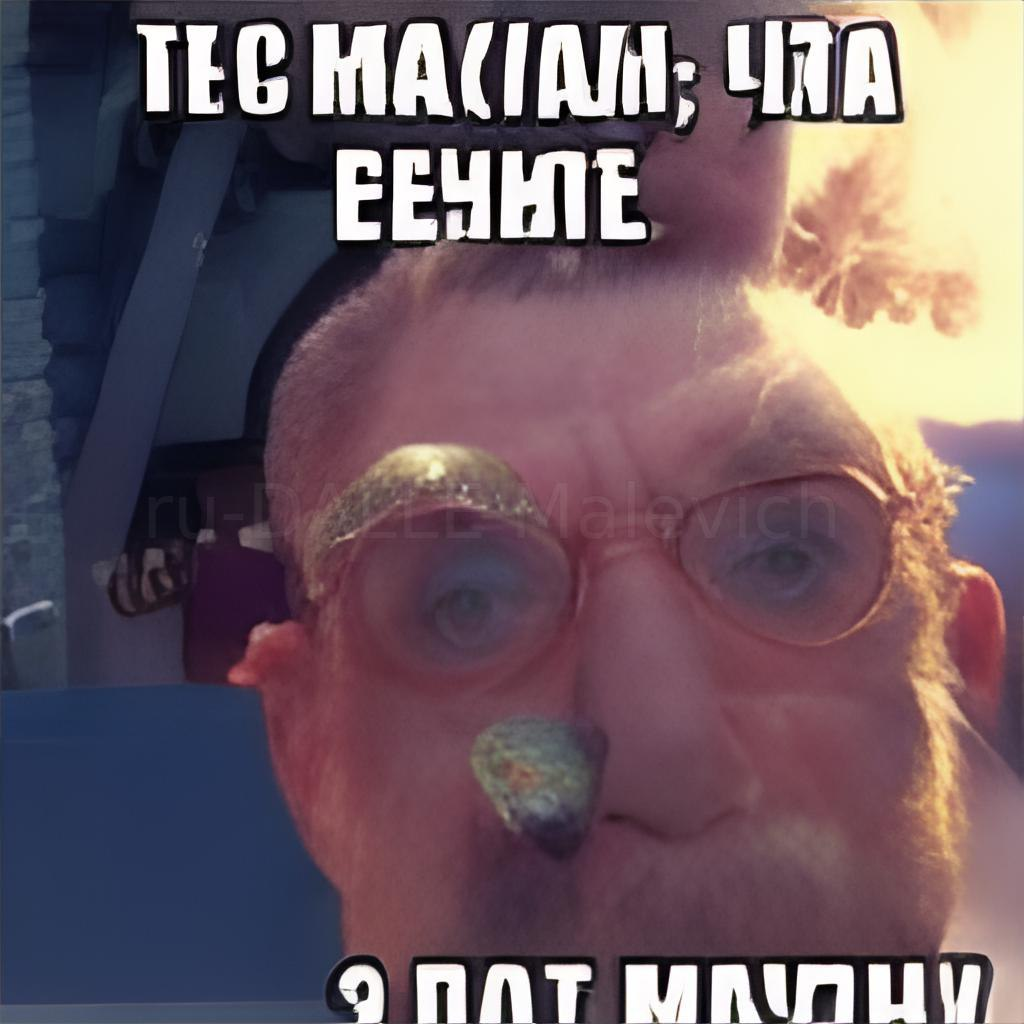

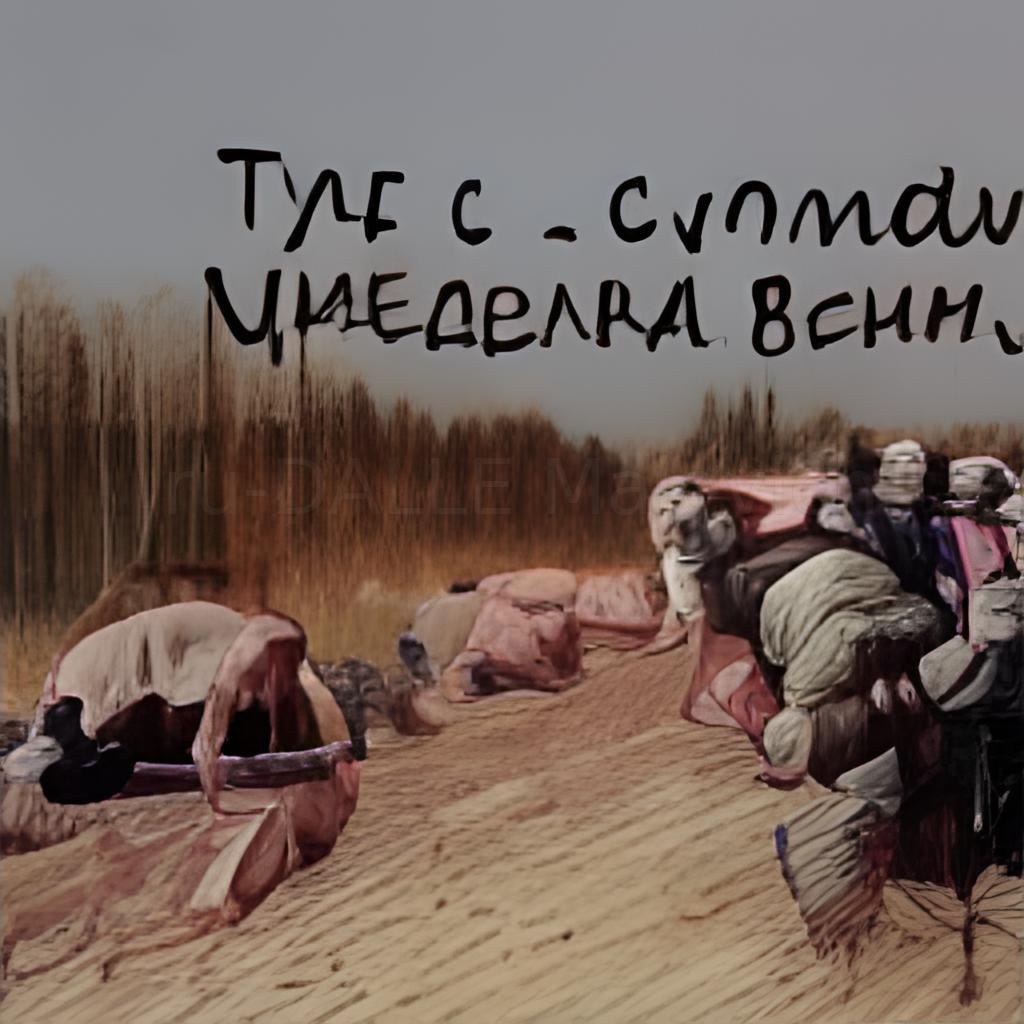

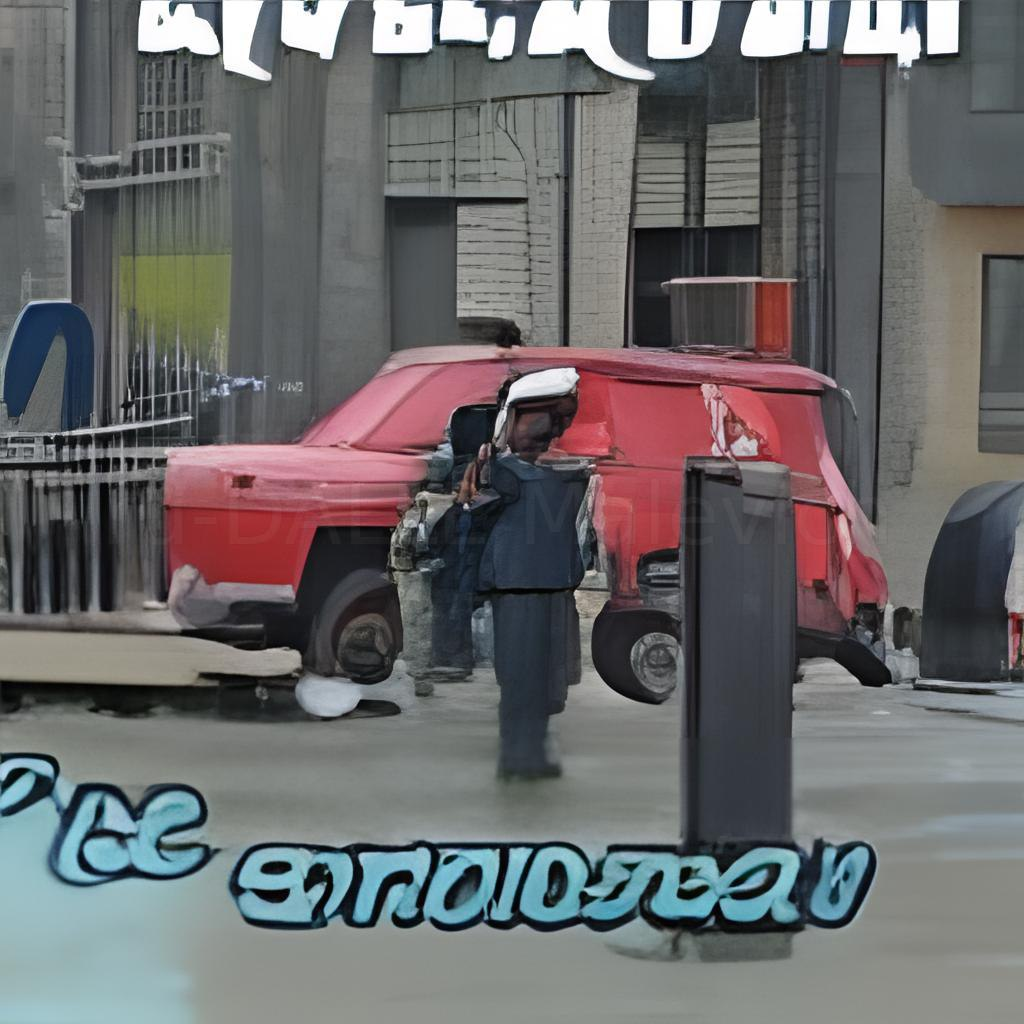